# Classify real data as model-free or model-based

### Import packages and set plotting settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys 
sys.path.append("/Users/johnzhou/research/decision-making")

from src.features.losses import mse_loss
from src.features.fit_curves import get_sigmoid_feats, epsilon_sigmoid
from src.data.real_data import RealSessionDataset, convert_real_actions
from src.data.synth_data import SynthBlockDataset
from src.data.environments import DynamicForagingTask
from src.data.experiments import RealExperiment
from src.utils import blockify, build_config, normalize_choice_block_side, average_choice_blocks, truncate_blocks
from src.models.hmm import HistogramHMM
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

/Users/johnzhou/miniconda3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "light navy",
    
    "faded green",
    "dusty purple",
    "orange",
    "windows blue",
    "marigold",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

### Load all real data filenames

In [3]:
directory = "/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging"
filenames = []
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filenames.append(f)
print(f"Loaded {len(filenames)} session files")

Loaded 48 session files


### Preprocess choice data

In chronological order of session for a given mouse
1. Remove trials with no-choice (nans)
2. Compute block lengths after nan removal
3. Partition actions into blocks
4. Normalize actions by correct side
5. Truncate action blocks at trial 15, remove blocks shorter than that
6. Append to list

In [12]:
choice_blocks = []
num_blocks = 0
fit_loss = mse_loss
block_bounds = []
total_blocks = 0

mouse_name = "MR18"
print(f"Loading data for mouse {mouse_name}")

for idx, filename in enumerate(sorted(filenames)):
    if mouse_name not in filename:
        continue
    block_count = 0
    try:
        expt = RealExperiment(filename, task_type=DynamicForagingTask)
    except ValueError:
        print(f"Failed to load {filename}")
        continue
    
    truncated_blocks = expt.get_preprocessed_blocks(min_len=15)
    
    choice_blocks += truncated_blocks
    block_count += len(truncated_blocks)
    total_blocks += len(truncated_blocks)
    
    print(f"{filename} yields {block_count}")
    block_bounds.append(total_blocks)


Loading data for mouse MR18
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221006_151941.mat yields 12
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221007_165441.mat yields 9
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221010_140054.mat yields 3
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221011_141239.mat yields 16
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221012_114333.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221013_123144.mat yields 13
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221014_132026.mat yields 14
/Users/johnzhou/research/decision-making/data/raw/dynamic_foraging/MR18_DynamicForaging_20221017_155907.mat yields 14
/Users/johnzhou/research/decis

In [13]:
print(block_bounds)

[12, 21, 24, 40, 53, 66, 80, 94, 108, 121, 136, 151]


### Fit real, preprocessed blocks with sigmoid function and get parameters

In [15]:
sigmoids = []
sigmoid_params = get_sigmoid_feats(choice_blocks, fit_loss, plot=False)
sigmoids.append(sigmoid_params)

100%|████████████████████████████████████████| 151/151 [00:00<00:00, 764.49it/s]


### Load data for HistHMM

In [16]:
expt_name = "generate_ssm_histogram"
repo_path = "/Users/johnzhou/research/decision-making"
expt_data = SynthBlockDataset(expt_name, repo_path)
boundary = list(expt_data.agent_labels == 1).index(True)

offset_bins = list(range(-1, 15))
mf_hist, mf_bins = np.histogramdd(expt_data.sigmoid_parameters[:boundary, :], bins=[100, 100, offset_bins])
mb_hist, mb_bins = np.histogramdd(expt_data.sigmoid_parameters[boundary:, :], bins=[100, 100, offset_bins])
emission_hists = [mf_hist / np.sum(mf_hist), mb_hist / np.sum(mb_hist)]
emission_bins = [mf_bins, mb_bins]

hist_model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)

### Delete any real data that falls outside the histogram (should be none, if so we have a problem)

In [17]:
X = np.squeeze(np.array(sigmoids))
lls = hist_model._compute_log_likelihood(X)
invalid_idxs = np.argwhere(np.all(lls==np.array([np.NINF, np.NINF]), axis=1)).flatten()
print(invalid_idxs)

X = np.delete(X, invalid_idxs, axis=0)
time_bins = X.shape[0]

[]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


## Fit models

### Fit HistHMM with different random states

In [18]:
print(X.shape)
models = []
scores = []
transmat = np.array([[0.5, 0.5],
                    [0.5, 0.5]])
for idx in range(10):
    # define our hidden Markov model
    model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
    model.fit(X)
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

hist_model = models[np.argmax(scores)]
n_states = hist_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
hist_predicted_states = hist_model.predict(X)
print(hist_predicted_states)

(151, 3)
Converged: True	Score: -450.584515723189


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.58461000073765
Converged: True	Score: -450.5846841272415


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5846388126923
Converged: True	Score: -450.584507102874


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5843885372469
Converged: True	Score: -450.58423773910806


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -450.5846269691353
Converged: True	Score: -450.58419151668517
Converged: True	Score: -450.58424999051635
The best model had a score of -450.58419151668517 and 2 states
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1]


/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:101: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


### Fit GaussianHMM with different random states

In [19]:
scores = []
models = []

for idx in range(10):
    # define our hidden Markov model
    model = GaussianHMM(n_components=2,
                            covariance_type='full',
                            random_state=idx)
    model.fit(X)  # 50/50 train/validate
    models.append(model)
    scores.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

gaussian_model = models[np.argmax(scores)]
n_states = gaussian_model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
predicted_states = gaussian_model.predict(X)
print(predicted_states)

Converged: True	Score: -99.36179753704246
Converged: True	Score: -96.93603775076798
Converged: True	Score: 388.1851360669374
Converged: True	Score: -93.79904910410242
Converged: True	Score: -94.10799318755471
Converged: True	Score: 393.64118647627396
Converged: True	Score: 397.88633323281687
Converged: True	Score: -113.05518023132986
Converged: True	Score: -96.91239737256714
Converged: True	Score: -93.7782739839921
The best model had a score of 397.88633323281687 and 2 states
[0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


### Fit Gaussian HMM from SSM library

In [20]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(X, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

hmm_z = hmm.most_likely_states(X)

LP: -73.9: 100%|█████████████████████████████| 100/100 [00:00<00:00, 250.87it/s]


## Plot most-likely sequence results

Rerun this cell to flip colors for GaussianHMMs, in case the states look flipped

([], [])

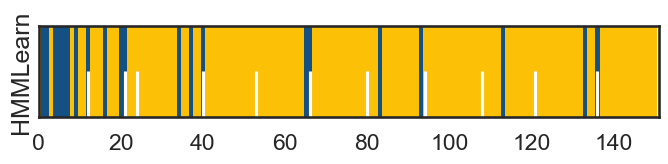

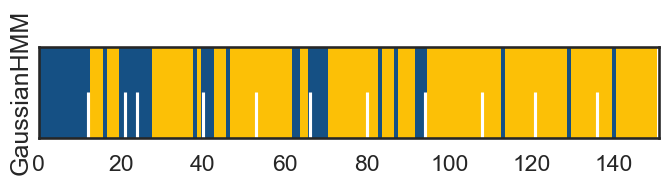

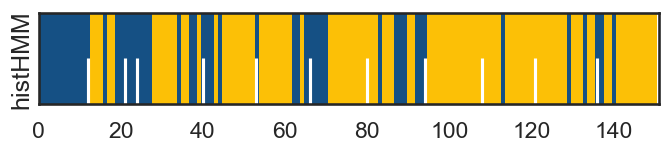

In [21]:
predicted_states = 1 - predicted_states
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(predicted_states[None,:], aspect="auto", cmap=cmap)
plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)
plt.ylabel("HMMLearn")
plt.yticks([])

hmm_z = 1 - hmm_z
plt.figure(figsize=(8, 4))
plt.subplot(312)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap)
plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)
plt.ylabel("GaussianHMM")
plt.yticks([])

hist_plot = np.array([-1 if state == 0 else state for state in hist_predicted_states])

plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap)
plt.vlines(block_bounds, color="white", ymin=0, ymax=0.25)
plt.ylim(0, 0.5)
plt.xlim(0, time_bins)

plt.ylabel("histHMM")
plt.yticks([])

# plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_predicted_states.pdf', format='pdf')

### Plot percentage of model-based blocks per session from HistHMM

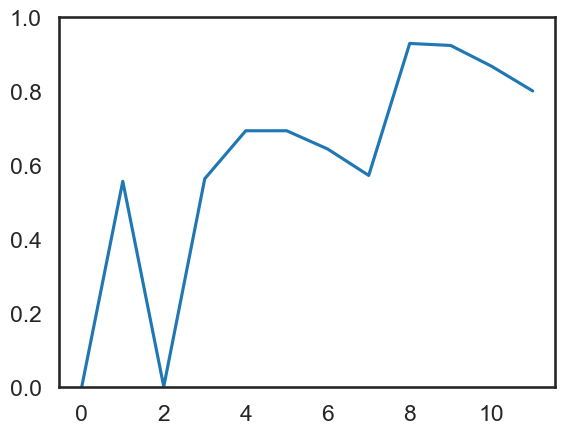

In [22]:
new_bounds = [0] + block_bounds
new_bounds = list(np.unique(np.array(new_bounds)))
indices = [(new_bounds[i], new_bounds[i+1]) for i in range(len(new_bounds) - 1)]

percent_mb = [np.mean(hist_predicted_states[start:end]) for start, end in indices]
plt.figure()
plt.ylim([0, 1])
plt.plot(percent_mb)

plt.savefig(f'/Users/johnzhou/Desktop/{mouse_name}_mb_percentage.eps', format='eps')

### Plot all sigmoid curves for each state

In [23]:
def visualize_sigmoids(sigmoid_params, idxs):
    params_list = sigmoid_params[idxs.flatten(), ...]
    plot_sigmoids(epsilon_sigmoid, params_list)
    
def visualize_regimes(state_preds, sigmoid_params):
    plt.figure()
    plt.subplot(211)
    idxs_0 = np.argwhere(state_preds == 0)
    visualize_sigmoids(sigmoid_params, idxs_0)
    plt.figure()
    plt.subplot(212)
    idxs_1 = np.argwhere(state_preds == 1)
    visualize_sigmoids(sigmoid_params, idxs_1)

Gaussian HMM from HMMLearn

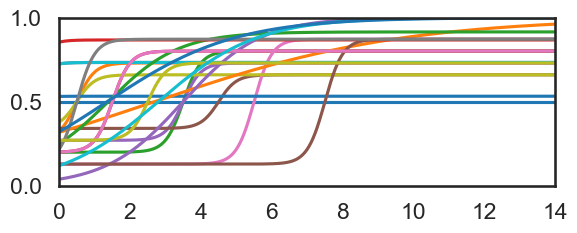

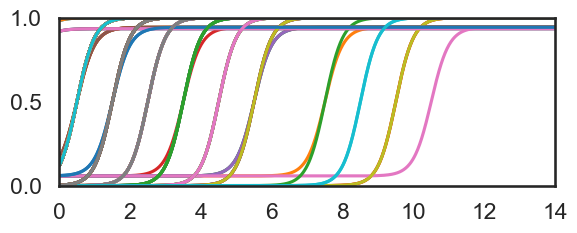

In [24]:
visualize_regimes(predicted_states, np.squeeze(X))

Gaussian HMM from SSM

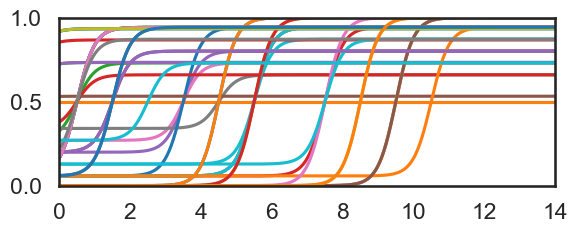

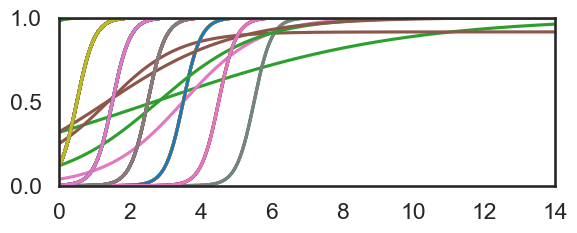

In [25]:
visualize_regimes(hmm_z, np.squeeze(X))

HistHMM

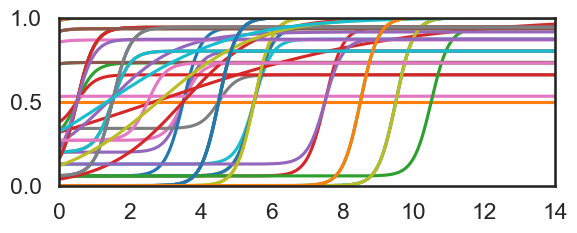

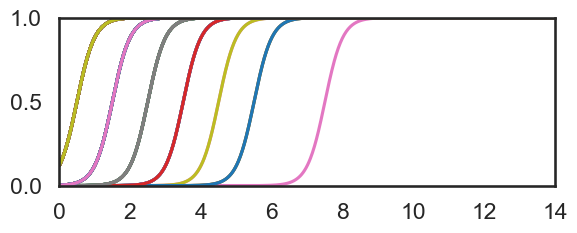

[[0.67403297 0.32596703]
 [0.19037621 0.80962379]]
Percentage model-based: 0.6556291390728477


In [26]:
visualize_regimes(hist_predicted_states, np.squeeze(X))
print(hist_model.transmat_)
print("Percentage model-based:", np.sum(hist_predicted_states)/hist_predicted_states.size)

### Plot learned transition matrix

[[0.67403297 0.32596703]
 [0.19037621 0.80962379]]


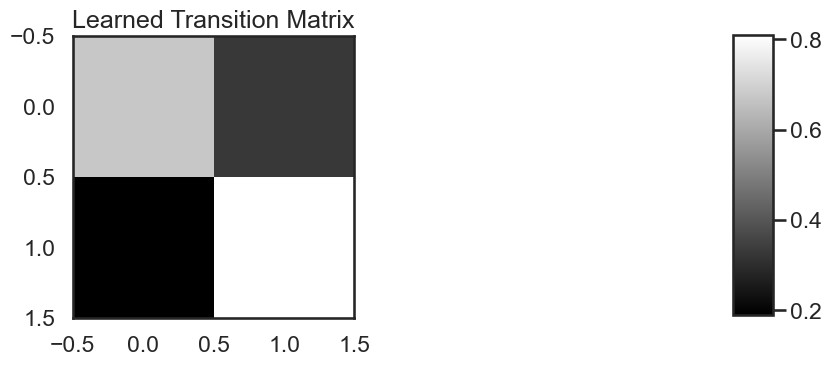

In [27]:
learned_transition_mat = hist_model.transmat_
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))

plt.subplot(121)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()